In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import statsmodels.api as sm

In [2]:
df = pd.read_csv('CarPrice_Assignment.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [3]:
df.isna().sum().sum()

0

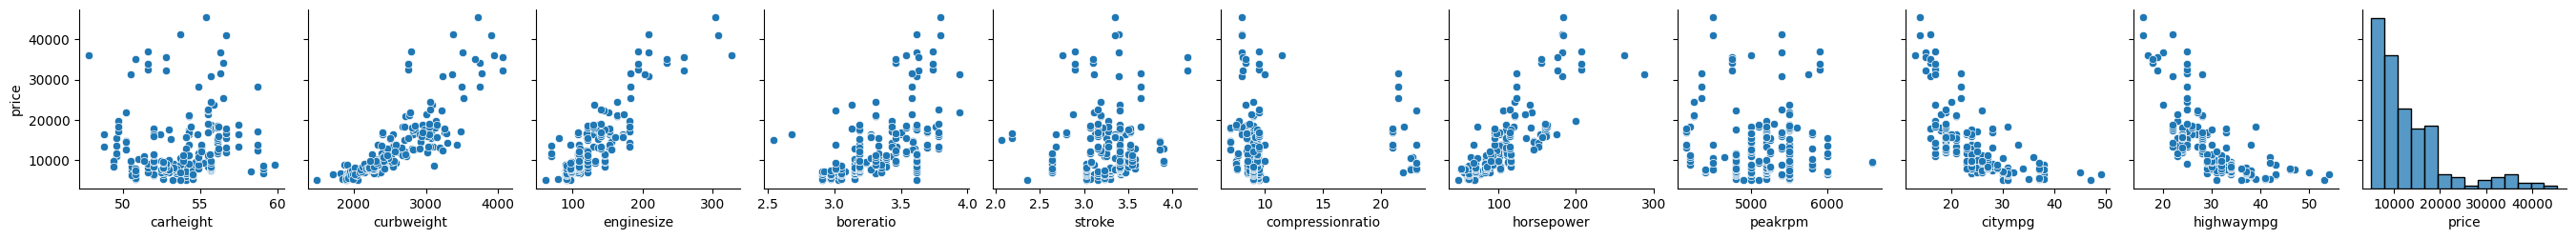

In [8]:
## Quick EDA for cols related to target
sns.pairplot(df.iloc[:,12:], y_vars='price');

In [38]:
## Make x and y variables
y = df['price'].copy()
X = df.drop(columns=['car_ID']).copy()
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
90,1,nissan gt-r,diesel,std,two,sedan,fwd,front,94.5,165.3,...,103,idi,2.99,3.47,21.9,55,4800,45,50,7099.0
173,-1,toyota corolla,gas,std,four,sedan,fwd,front,102.4,175.6,...,122,mpfi,3.31,3.54,8.7,92,4200,29,34,8948.0
93,1,nissan titan,gas,std,four,wagon,fwd,front,94.5,170.2,...,97,2bbl,3.15,3.29,9.4,69,5200,31,37,7349.0
5,2,audi fox,gas,std,two,sedan,fwd,front,99.8,177.3,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250.0
167,2,toyota corona liftback,gas,std,two,hardtop,rwd,front,98.4,176.2,...,146,mpfi,3.62,3.50,9.3,116,4800,24,30,8449.0


In [59]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)

## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)

In [73]:
## make only encoders/scalers because there isn't a missing value 
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#imp = SimpleImputer(strategy='mean')
#scaler = StandardScaler()

preprocessor = make_column_transformer((ohe,cat_cols)
                                        #,(scaler, num_cols)
                                            , remainder='passthrough')

In [74]:
## fit the col transformer
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['CarName', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem'])])

In [75]:
pd.DataFrame(preprocessor.transform(X_train).round(2))

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2017.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,7099.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2326.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,8948.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2024.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,7349.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2507.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,15250.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2540.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0,8449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3139.0,181.0,3.43,3.27,9.0,160.0,5200.0,19.0,25.0,18399.0
149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3055.0,164.0,3.31,3.19,9.0,121.0,4250.0,20.0,25.0,24565.0
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1938.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,6849.0
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3016.0,171.0,3.27,3.35,9.3,161.0,5200.0,19.0,24.0,15998.0


In [76]:
#getting columns names
fit_ohe = pd.DataFrame(ohe.fit_transform(X_train[cat_cols]))

In [77]:
names= []
names.extend(ohe.get_feature_names_out())
len(names)

155

In [78]:
names.extend(num_cols)
len(names)

170

In [84]:
#transforming df's
X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=names, index=X_train.index)
X_train_df.head()



,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2017.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,7099.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2326.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,8948.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2024.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,7349.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2507.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,15250.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2540.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0,8449.0


In [83]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=names, index=X_test.index)
X_test_df.head()



,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3230.0,209.0,3.62,3.39,8.00,182.0,5400.0,16.0,22.0,30760.000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3053.0,131.0,3.13,3.40,7.00,160.0,5500.0,16.0,22.0,17859.167
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2302.0,120.0,3.33,3.47,8.50,97.0,5200.0,27.0,34.0,9549.000
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2658.0,121.0,3.54,3.07,9.31,110.0,5250.0,21.0,28.0,11850.000
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3750.0,183.0,3.58,3.64,21.50,123.0,4350.0,22.0,25.0,28248.000


In [86]:
## adding a constant to X_train (not rewriting the df yet-confirming expected results first)

X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display(X_train_df.head(2), X_test_df.head(2))



,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,const
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,7099.0,1.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,8948.0,1.0


,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,const
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,209.0,3.62,3.39,8.0,182.0,5400.0,16.0,22.0,30760.000,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,131.0,3.13,3.40,7.0,160.0,5500.0,16.0,22.0,17859.167,1.0


In [89]:
#instantiating model

model = sm.OLS(y_train, X_train_df, hasconst=True)


In [90]:
# Fitting the model (no data in .fit) and saving the result as new var
result = model.fit()


In [91]:
## get model performance metrics
result.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.124e+26
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           1.21e-67
Time:                        09:32:54   Log-Likelihood:                 3417.8
No. Observations:                 153   AIC:                            -6540.
Df Residuals:                       5   BIC:                            -6091.
Df Model:                         147                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
CarName_Nissan versa                     -3.82e-11   8.04e-10     -0.047      0.964   -2.11e-09    2.03e-09
CarName_alfa-romero Quadrifoglio         6.003e-11   9.39e-10      0.064      0.952   -2.35e-09    2.47e-09
CarName_alfa-romero giulia               4.093e-11   7.67e-10      0.053      0.960   -1.93e-09    2.01e-09
CarName_alfa-romero stelvio                  1e-11   7.44e-10      0.013      0.990    -1.9e-09    1.92e-09
CarName_audi 100 ls                      7.276e-12   5.06e-10      0.014      0.989   -1.29e-09    1.31e-09
CarName_audi 100ls                      -4.547e-12   5.24e-10     -0.009      0.993   -1.35e-09    1.34e-09
CarName_audi 4000                        8.731e-11   9.03e-10      0.097      0.927   -2.23e-09    2.41e-09
CarName_audi 5000                       -2.228e-11   5.83e-10     -0.038      0.971   -1.52e-09    1.48e-09
CarName_audi fox                         -1.16e-10   1.63e-09     -0.071      0.946    -4.3e-09    4.07e-09
CarName_bmw 320i                         3.638e-12   8.25e-10      0.004      0.997   -2.12e-09    2.12e-09
CarName_bmw x1                          -1.455e-11   1.63e-09     -0.009      0.993   -4.21e-09    4.18e-09
CarName_bmw x3                           2.001e-11   1.26e-09      0.016      0.988   -3.22e-09    3.26e-09
CarName_bmw z4                           1.037e-10   1.29e-09      0.080      0.939   -3.22e-09    3.43e-09
CarName_buick opel isuzu deluxe          6.185e-11   9.98e-10      0.062      0.953    -2.5e-09    2.63e-09
CarName_buick regal sport coupe (turbo) -1.091e-10   1.45e-09     -0.075      0.943   -3.84e-09    3.62e-09
CarName_buick skyhawk                    1.492e-10   1.75e-09      0.085      0.935   -4.35e-09    4.65e-09
CarName_buick skylark                    2.547e-11   9.72e-10      0.026      0.980   -2.47e-09    2.52e-09
CarName_chevrolet vega 2300             -3.456e-11   6.77e-10     -0.051      0.961   -1.78e-09    1.71e-09
CarName_dodge challenger se             -5.548e-11   7.96e-10     -0.070      0.947    -2.1e-09    1.99e-09
CarName_dodge colt (sw)                 -5.639e-11   8.84e-10     -0.064      0.952   -2.33e-09    2.22e-09
CarName_dodge coronet custom            -8.549e-11   1.13e-09     -0.076      0.943   -2.98e-09    2.81e-09
CarName_dodge d200                      -9.186e-11   1.16e-09     -0.079      0.940   -3.07e-09    2.89e-09
CarName_dodge dart custom               -4.547e-11   6.22e-10     -0.073      0.945   -1.64e-09    1.55e-09
CarName_dodge rampage                   -3.638e-11   8.94e-10     -0.041      0.969   -2.34e-09    2.26e-09
CarName_honda accord                    -6.912e-11    1.8e-09     -0.038      0.971    -4.7e-09    4.56e-09
CarName_honda accord cvcc               -8.731e-11   1.35e-

In [92]:
# after fitting statsmodels, use the result variable with .predict()
test_preds = result.predict(X_test_df)


In [95]:
print('Testing r2:', r2_score(y_test, test_preds))



Testing r2: 1.0
